In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
from tqdm import tqdm_notebook

import sklearn.metrics as metrics

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard

# 256 x 256

## Load data

In [1]:
import numpy as np
import os
from tqdm import tqdm_notebook
import cv2

directory = './data/new_data_y/test_data/defective_pics/'

data_256_defect = []
# i = 0
for file in tqdm_notebook(os.listdir(directory)):
    if file.endswith(".jpg"):
        img = cv2.imread(directory+file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_resize = cv2.resize(gray, (256, 256))
        
        data_256_defect.append(gray_resize/255.)

data_256_defect = np.reshape(data_256_defect, (len(data_256_defect), 256, 256, 1))


# df_y = pd.DataFrame(data_y.T)
# store = pd.HDFStore('./machine_data.h5')
# store['/machine_y_128'] = df_y
# store.close()

In [3]:
import numpy as np
import os
from tqdm import tqdm_notebook
import cv2

directory = './data/new_data_y/test_data/holdout_images/'

data_256_holdout= []
# i = 0
for file in tqdm_notebook(os.listdir(directory)):
    if file.endswith(".jpg"):
        img = cv2.imread(directory+file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_resize = cv2.resize(gray, (256, 256))
        
        data_256_holdout.append(gray_resize/255.)

data_256_holdout = np.reshape(data_256_holdout, (len(data_256_holdout), 256, 256, 1))


# df_y = pd.DataFrame(data_y.T)
# store = pd.HDFStore('./machine_data.h5')
# store['/machine_y_128'] = df_y
# store.close()

## Build model

In [4]:
#Random seed
np.random.seed(42)

# Network architecture
input_image_256_cnn = Input(shape=(256, 256, 1))

# Encoding
encoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(input_image_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)

encoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)

encoded_256_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)


# Decoding
decoded_256_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(1, (5, 5), activation='relu', padding='same')(decoded_256_cnn)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# Autoencoder
autoencoder_256_cnn = Model(input_image_256_cnn, decoded_256_cnn)

# Encoder
encoder_256_cnn = Model(input_image_256_cnn, encoded_256_cnn)

autoencoder_256_cnn.compile(optimizer='adadelta', loss='mse')

In [6]:
# load weights into new model
autoencoder_256_cnn.load_weights("./application/static/index/autoencoder_256_cnn.h5")
print("Loaded model from disk")

Loaded model from disk


In [7]:
# Proxy testing
# encoded_imgs_256_cnn = encoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn = autoencoder_256_cnn.predict(data_256_holdout[:, :, :, ])

In [8]:
difference_mean = []
for i in range(data_256_holdout.shape[0]):
    diff = (data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_256_holdout.shape[0]):
    diff = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_256_holdout.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_holdout[i, :, :, ]*255., (256, 256)))
    
    difference_mse.append(diff)
    

In [9]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(7.825401298692363, 2742.4923271817106, 157.04298879739292)

In [10]:
total_diff = []
anomalies = []
for i in range(data_256_holdout.shape[0]):
    diff_1 = (data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_holdout[i, :, :, ]*255., (256, 256)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1420:
        anomalies.append(1)

In [11]:
np.mean(total_diff)

959.429036701673

In [12]:
# Proxy testing
# encoded_imgs_256_cnn = encoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn = autoencoder_256_cnn.predict(data_256_defect[:, :, :, ])

In [13]:
difference_mean = []
for i in range(data_256_defect.shape[0]):
    diff = (data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_256_defect.shape[0]):
    diff = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_256_defect.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_defect[i, :, :, ]*255., (256, 256)))
    
    difference_mse.append(diff)
    

In [14]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(7.519283147662622, 2842.1192828614417, 153.20103604428348)

In [15]:
total_diff = []
anomalies = []
for i in range(data_256_defect.shape[0]):
    diff_1 = (data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_defect[i, :, :, ]*255., (256, 256)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1420:
        anomalies.append(1)

In [16]:
np.mean(total_diff)

990.9370686776178

In [18]:
# Proxy testing
# encoded_imgs_256_cnn = encoder_256_cnn.predict(data_256_holdout[:, :, :, ])
# decoded_imgs_256_cnn_holdout = autoencoder_256_cnn.predict(data_256_holdout[:, :, :, ])
# decoded_imgs_256_cnn_defect = autoencoder_256_cnn.predict(data_256_defect[:, :, :, ])


for threshold in range(2000,3000,50):
    total_diff_holdout = []
    anomalies_holdout = []
    
    for i in range(data_256_holdout.shape[0]):
#         diff_1 = np.absolute((data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn_holdout[i]*255.).mean())
        diff_2 = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn_holdout[i]*255.)
#         diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn_holdout[i]*255., (256, 256)),
#                                           np.reshape(data_256_holdout[i, :, :, ]*255., (256, 256)))
#         diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

#         total_diff_holdout.append(diff_total)

        if diff_2 >= threshold:
            anomalies_holdout.append(1)

    FP = np.sum(anomalies_holdout)
    TN = data_256_holdout.shape[0] - FP

    total_diff_defect = []
    anomalies_defect = []
    for i in range(data_256_defect.shape[0]):
#         diff_1 = np.absolute((data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn_defect[i]*255.).mean())
        diff_2 = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn_defect[i]*255.)
#         diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn_defect[i]*255., (256, 256)),
#                                           np.reshape(data_256_defect[i, :, :, ]*255., (256, 256)))
#         diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

#         total_diff_defect.append(diff_total)

        if diff_2 >= threshold:
            anomalies_defect.append(1)

    TP = np.sum(anomalies_defect)
    FN = data_256_defect.shape[0] - TP

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2 * (precision*recall)/(precision+recall)

    print("Threshold: {0}".format(threshold))
    print("False positive: {0}".format(FP))
    print("True negative: {0}".format(TN))
    print("True positive: {0}".format(TP))
    print("False negative: {0}".format(FN))
    print("Precision: {0}".format(precision))
    print("Recall: {0}".format(recall))
    print("F1: {0}".format(F1))
    print("----------")

Threshold: 2000
False positive: 1170
True negative: 1107
True positive: 74
False negative: 52
Precision: 0.0594855305466238
Recall: 0.5873015873015873
F1: 0.10802919708029197
----------
Threshold: 2050
False positive: 1164
True negative: 1113
True positive: 73
False negative: 53
Precision: 0.05901374292643492
Recall: 0.5793650793650794
F1: 0.1071166544387381
----------
Threshold: 2100
False positive: 1142
True negative: 1135
True positive: 72
False negative: 54
Precision: 0.05930807248764415
Recall: 0.5714285714285714
F1: 0.10746268656716418
----------
Threshold: 2150
False positive: 1114
True negative: 1163
True positive: 72
False negative: 54
Precision: 0.06070826306913996
Recall: 0.5714285714285714
F1: 0.1097560975609756
----------
Threshold: 2200
False positive: 1104
True negative: 1173
True positive: 71
False negative: 55
Precision: 0.06042553191489362
Recall: 0.5634920634920635
F1: 0.10914681014604151
----------
Threshold: 2250
False positive: 1089
True negative: 1188
True positi

## Build model deeper

In [15]:
#Random seed
np.random.seed(42)

# Network architecture
input_image_256_cnn = Input(shape=(256, 256, 1))

# Encoding
encoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(input_image_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)

encoded_256_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)

encoded_256_cnn = Conv2D(8, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)

encoded_256_cnn = Conv2D(4, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)


# Decoding
decoded_256_cnn = Conv2D(4, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(8, (5, 5), activation='relu', padding='same')(decoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(decoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(decoded_256_cnn)

In [16]:
# Autoencoder
autoencoder_256_cnn = Model(input_image_256_cnn, decoded_256_cnn)

# Encoder
encoder_256_cnn = Model(input_image_256_cnn, encoded_256_cnn)

autoencoder_256_cnn.compile(optimizer='adadelta', loss='mse')

In [17]:
# load weights into new model
autoencoder_256_cnn.load_weights("./autoencoder_cnn_256_deep.h5")
print("Loaded model from disk")

Loaded model from disk


In [19]:
# Proxy testing
# encoded_imgs_256_cnn = encoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn = autoencoder_256_cnn.predict(data_256_holdout[:, :, :, ])

In [20]:
difference_mean = []
for i in range(data_256_holdout.shape[0]):
    diff = (data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_256_holdout.shape[0]):
    diff = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_256_holdout.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_holdout[i, :, :, ]*255., (256, 256)))
    
    difference_mse.append(diff)
    

In [21]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(-2.7084635025785904, 1767.2543136092725, 51.96146346719032)

In [22]:
total_diff = []
anomalies = []
for i in range(data_256_holdout.shape[0]):
    diff_1 = (data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_holdout[i, :, :, ]*255., (256, 256)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1420:
        anomalies.append(1)

In [23]:
np.mean(total_diff)

599.4474134793818

In [24]:
# Proxy testing
# encoded_imgs_256_cnn = encoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn = autoencoder_256_cnn.predict(data_256_defect[:, :, :, ])

In [25]:
difference_mean = []
for i in range(data_256_defect.shape[0]):
    diff = (data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_256_defect.shape[0]):
    diff = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_256_defect.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_defect[i, :, :, ]*255., (256, 256)))
    
    difference_mse.append(diff)
    

In [26]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(-2.9495767848521712, 1769.9632095013328, 50.37311618723858)

In [27]:
total_diff = []
anomalies = []
for i in range(data_256_defect.shape[0]):
    diff_1 = (data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_defect[i, :, :, ]*255., (256, 256)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1420:
        anomalies.append(1)

In [28]:
np.mean(total_diff)

599.7376271382274

In [34]:
# Proxy testing
# encoded_imgs_256_cnn = encoder_256_cnn.predict(data_256_holdout[:, :, :, ])
# decoded_imgs_256_cnn_holdout = autoencoder_256_cnn.predict(data_256_holdout[:, :, :, ])
# decoded_imgs_256_cnn_defect = autoencoder_256_cnn.predict(data_256_defect[:, :, :, ])


for threshold in np.arange(599.30,600,0.05):
    total_diff_holdout = []
    anomalies_holdout = []
    
    for i in range(data_256_holdout.shape[0]):
        diff_1 = np.absolute((data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn_holdout[i]*255.).mean())
        diff_2 = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn_holdout[i]*255.)
        diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn_holdout[i]*255., (256, 256)),
                                          np.reshape(data_256_holdout[i, :, :, ]*255., (256, 256)))
        diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

        total_diff_holdout.append(diff_total)

        if diff_total >= threshold:
            anomalies_holdout.append(1)

    FP = np.sum(anomalies_holdout)
    TN = data_256_holdout.shape[0] - FP

    total_diff_defect = []
    anomalies_defect = []
    for i in range(data_256_defect.shape[0]):
        diff_1 = np.absolute((data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn_defect[i]*255.).mean())
        diff_2 = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn_defect[i]*255.)
        diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn_defect[i]*255., (256, 256)),
                                          np.reshape(data_256_defect[i, :, :, ]*255., (256, 256)))
        diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

        total_diff_defect.append(diff_total)

        if diff_total >= threshold:
            anomalies_defect.append(1)

    TP = np.sum(anomalies_defect)
    FN = data_256_defect.shape[0] - TP

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2 * (precision*recall)/(precision+recall)

    print("Threshold: {0}".format(threshold))
    print("False positive: {0}".format(FP))
    print("True negative: {0}".format(TN))
    print("True positive: {0}".format(TP))
    print("False negative: {0}".format(FN))
    print("Precision: {0}".format(precision))
    print("Recall: {0}".format(recall))
    print("F1: {0}".format(F1))
    print("----------")

Threshold: 599.3
False positive: 884
True negative: 1393
True positive: 56
False negative: 70
Precision: 0.059574468085106386
Recall: 0.4444444444444444
F1: 0.1050656660412758
----------
Threshold: 599.3499999999999
False positive: 884
True negative: 1393
True positive: 56
False negative: 70
Precision: 0.059574468085106386
Recall: 0.4444444444444444
F1: 0.1050656660412758
----------
Threshold: 599.3999999999999
False positive: 884
True negative: 1393
True positive: 56
False negative: 70
Precision: 0.059574468085106386
Recall: 0.4444444444444444
F1: 0.1050656660412758
----------
Threshold: 599.4499999999998
False positive: 884
True negative: 1393
True positive: 56
False negative: 70
Precision: 0.059574468085106386
Recall: 0.4444444444444444
F1: 0.1050656660412758
----------
Threshold: 599.4999999999998
False positive: 884
True negative: 1393
True positive: 56
False negative: 70
Precision: 0.059574468085106386
Recall: 0.4444444444444444
F1: 0.1050656660412758
----------
Threshold: 599.54

## Build model (Euclidian)

In [4]:
import keras.backend as K


def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true)))

Using TensorFlow backend.


In [7]:
#Random seed
np.random.seed(42)

# Network architecture
input_image_256_cnn = Input(shape=(256, 256, 1))

# Encoding
encoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(input_image_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)

encoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)

encoded_256_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)



# Decoding
decoded_256_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(decoded_256_cnn)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# Autoencoder
autoencoder_256_cnn = Model(input_image_256_cnn, decoded_256_cnn)

# Encoder
encoder_256_cnn = Model(input_image_256_cnn, encoded_256_cnn)

autoencoder_256_cnn.compile(optimizer='adadelta', loss=euclidean_distance_loss)

In [9]:
# load weights into new model
autoencoder_256_cnn.load_weights("./autoencoder_cnn_256_deep_euclidian.h5")
print("Loaded model from disk")

Loaded model from disk


In [10]:
# Proxy testing
# encoded_imgs_256_cnn = encoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn = autoencoder_256_cnn.predict(data_256_holdout[:, :, :, ])

In [11]:
difference_mean = []
for i in range(data_256_holdout.shape[0]):
    diff = (data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_256_holdout.shape[0]):
    diff = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_256_holdout.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_holdout[i, :, :, ]*255., (256, 256)))
    
    difference_mse.append(diff)
    

In [12]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(-3.997319675844746, 1590.2296865912588, 45.34911626181586)

In [13]:
total_diff = []
anomalies = []
for i in range(data_256_holdout.shape[0]):
    diff_1 = (data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_holdout[i, :, :, ]*255., (256, 256)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1420:
        anomalies.append(1)

In [14]:
np.mean(total_diff)

808.9238498654195

In [14]:
np.mean(total_diff)

538.4218894484859

In [15]:
# Proxy testing
# encoded_imgs_256_cnn = encoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn = autoencoder_256_cnn.predict(data_256_defect[:, :, :, ])

In [16]:
difference_mean = []
for i in range(data_256_defect.shape[0]):
    diff = (data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_256_defect.shape[0]):
    diff = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_256_defect.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_defect[i, :, :, ]*255., (256, 256)))
    
    difference_mse.append(diff)
    

In [17]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(7.359600185918477, 2267.1331565962882, 90.47718744222857)

In [17]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(-4.197518206051528, 1624.0843338917268, 44.770369910100094)

In [18]:
total_diff = []
anomalies = []
for i in range(data_256_defect.shape[0]):
    diff_1 = (data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_defect[i, :, :, ]*255., (256, 256)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1420:
        anomalies.append(1)

In [19]:
np.mean(total_diff)

780.4400815940638

In [19]:
np.mean(total_diff)

549.3368712466058

In [21]:
# Proxy testing
# encoded_imgs_256_cnn = encoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn_holdout = autoencoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn_defect = autoencoder_256_cnn.predict(data_256_defect[:, :, :, ])


for threshold in range(1570,1640,5):
    total_diff_holdout = []
    anomalies_holdout = []
    
    for i in range(data_256_holdout.shape[0]):
#         diff_1 = np.absolute((data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn_holdout[i]*255.).mean())
        diff_2 = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn_holdout[i]*255.)
#         diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn_holdout[i]*255., (256, 256)),
#                                           np.reshape(data_256_holdout[i, :, :, ]*255., (256, 256)))
#         diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

#         total_diff_holdout.append(diff_total)

        if diff_2 >= threshold:
            anomalies_holdout.append(1)

    FP = np.sum(anomalies_holdout)
    TN = data_256_holdout.shape[0] - FP

    total_diff_defect = []
    anomalies_defect = []
    for i in range(data_256_defect.shape[0]):
#         diff_1 = np.absolute((data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn_defect[i]*255.).mean())
        diff_2 = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn_defect[i]*255.)
#         diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn_defect[i]*255., (256, 256)),
#                                           np.reshape(data_256_defect[i, :, :, ]*255., (256, 256)))
#         diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

#         total_diff_defect.append(diff_total)

        if diff_2 >= threshold:
            anomalies_defect.append(1)

    TP = np.sum(anomalies_defect)
    FN = data_256_defect.shape[0] - TP

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2 * (precision*recall)/(precision+recall)

    print("Threshold: {0}".format(threshold))
    print("False positive: {0}".format(FP))
    print("True negative: {0}".format(TN))
    print("True positive: {0}".format(TP))
    print("False negative: {0}".format(FN))
    print("Precision: {0}".format(precision))
    print("Recall: {0}".format(recall))
    print("F1: {0}".format(F1))
    print("----------")

Threshold: 1570
False positive: 1084
True negative: 1193
True positive: 67
False negative: 59
Precision: 0.05821025195482189
Recall: 0.5317460317460317
F1: 0.10493343774471417
----------
Threshold: 1575
False positive: 1077
True negative: 1200
True positive: 67
False negative: 59
Precision: 0.05856643356643357
Recall: 0.5317460317460317
F1: 0.10551181102362206
----------
Threshold: 1580
False positive: 1075
True negative: 1202
True positive: 67
False negative: 59
Precision: 0.05866900175131348
Recall: 0.5317460317460317
F1: 0.10567823343848579
----------
Threshold: 1585
False positive: 1073
True negative: 1204
True positive: 67
False negative: 59
Precision: 0.058771929824561406
Recall: 0.5317460317460317
F1: 0.10584518167456558
----------
Threshold: 1590
False positive: 1072
True negative: 1205
True positive: 67
False negative: 59
Precision: 0.058823529411764705
Recall: 0.5317460317460317
F1: 0.10592885375494071
----------
Threshold: 1595
False positive: 1069
True negative: 1208
True p

## Build model (Euclidian 50 epochs)

In [36]:
import keras.backend as K


def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true)))

In [37]:
#Random seed
np.random.seed(42)

# Network architecture
input_image_256_cnn = Input(shape=(256, 256, 1))

# Encoding
encoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(input_image_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)

encoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)

encoded_256_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)



# Decoding
decoded_256_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(decoded_256_cnn)

In [38]:
# Autoencoder
autoencoder_256_cnn = Model(input_image_256_cnn, decoded_256_cnn)

# Encoder
encoder_256_cnn = Model(input_image_256_cnn, encoded_256_cnn)

autoencoder_256_cnn.compile(optimizer='adadelta', loss=euclidean_distance_loss)

In [39]:
# load weights into new model
autoencoder_256_cnn.load_weights("./autoencoder_cnn_256_deep_euclidian_50.h5")
print("Loaded model from disk")

Loaded model from disk


In [40]:
# Proxy testing
# encoded_imgs_256_cnn = encoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn = autoencoder_256_cnn.predict(data_256_holdout[:, :, :, ])

In [41]:
difference_mean = []
for i in range(data_256_holdout.shape[0]):
    diff = (data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_256_holdout.shape[0]):
    diff = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_256_holdout.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_holdout[i, :, :, ]*255., (256, 256)))
    
    difference_mse.append(diff)
    

In [12]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(-3.997319675844746, 1590.2296865912588, 45.34911626181586)

In [42]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(3.0788233063812926, 1783.3369106227462, 64.85057332636224)

In [43]:
total_diff = []
anomalies = []
for i in range(data_256_holdout.shape[0]):
    diff_1 = (data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_holdout[i, :, :, ]*255., (256, 256)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1420:
        anomalies.append(1)

In [14]:
np.mean(total_diff)

808.9238498654195

In [44]:
np.mean(total_diff)

610.9178813943116

In [45]:
# Proxy testing
# encoded_imgs_256_cnn = encoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn = autoencoder_256_cnn.predict(data_256_defect[:, :, :, ])

In [46]:
difference_mean = []
for i in range(data_256_defect.shape[0]):
    diff = (data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_256_defect.shape[0]):
    diff = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_256_defect.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_defect[i, :, :, ]*255., (256, 256)))
    
    difference_mse.append(diff)
    

In [47]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(2.9233018364931116, 1802.2804387181343, 61.28887898917319)

In [48]:
total_diff = []
anomalies = []
for i in range(data_256_defect.shape[0]):
    diff_1 = (data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_defect[i, :, :, ]*255., (256, 256)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1420:
        anomalies.append(1)

In [49]:
np.mean(total_diff)

615.9425644494543

In [19]:
np.mean(total_diff)

549.3368712466058

In [50]:
# Proxy testing
# encoded_imgs_256_cnn = encoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn_holdout = autoencoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn_defect = autoencoder_256_cnn.predict(data_256_defect[:, :, :, ])


for threshold in range(1760,1815,5):
    total_diff_holdout = []
    anomalies_holdout = []
    
    for i in range(data_256_holdout.shape[0]):
#         diff_1 = np.absolute((data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn_holdout[i]*255.).mean())
        diff_2 = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn_holdout[i]*255.)
#         diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn_holdout[i]*255., (256, 256)),
#                                           np.reshape(data_256_holdout[i, :, :, ]*255., (256, 256)))
#         diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

#         total_diff_holdout.append(diff_total)

        if diff_2 >= threshold:
            anomalies_holdout.append(1)

    FP = np.sum(anomalies_holdout)
    TN = data_256_holdout.shape[0] - FP

    total_diff_defect = []
    anomalies_defect = []
    for i in range(data_256_defect.shape[0]):
#         diff_1 = np.absolute((data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn_defect[i]*255.).mean())
        diff_2 = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn_defect[i]*255.)
#         diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn_defect[i]*255., (256, 256)),
#                                           np.reshape(data_256_defect[i, :, :, ]*255., (256, 256)))
#         diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

#         total_diff_defect.append(diff_total)

        if diff_2 >= threshold:
            anomalies_defect.append(1)

    TP = np.sum(anomalies_defect)
    FN = data_256_defect.shape[0] - TP

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2 * (precision*recall)/(precision+recall)

    print("Threshold: {0}".format(threshold))
    print("False positive: {0}".format(FP))
    print("True negative: {0}".format(TN))
    print("True positive: {0}".format(TP))
    print("False negative: {0}".format(FN))
    print("Precision: {0}".format(precision))
    print("Recall: {0}".format(recall))
    print("F1: {0}".format(F1))
    print("----------")

Threshold: 1760
False positive: 993
True negative: 1284
True positive: 62
False negative: 64
Precision: 0.058767772511848344
Recall: 0.49206349206349204
F1: 0.10499576629974598
----------
Threshold: 1765
False positive: 992
True negative: 1285
True positive: 62
False negative: 64
Precision: 0.058823529411764705
Recall: 0.49206349206349204
F1: 0.10508474576271187
----------
Threshold: 1770
False positive: 990
True negative: 1287
True positive: 62
False negative: 64
Precision: 0.058935361216730035
Recall: 0.49206349206349204
F1: 0.10526315789473685
----------
Threshold: 1775
False positive: 989
True negative: 1288
True positive: 61
False negative: 65
Precision: 0.058095238095238096
Recall: 0.48412698412698413
F1: 0.10374149659863945
----------
Threshold: 1780
False positive: 989
True negative: 1288
True positive: 60
False negative: 66
Precision: 0.057197330791229746
Recall: 0.47619047619047616
F1: 0.10212765957446808
----------
Threshold: 1785
False positive: 988
True negative: 1289
True

## Build model (sigmoid 32-32-16)

In [22]:
#Random seed
np.random.seed(42)

# Network architecture
input_image_256_cnn = Input(shape=(256, 256, 1))

# Encoding
encoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(input_image_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)

encoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)

encoded_256_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)



# Decoding
decoded_256_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(decoded_256_cnn)

In [23]:
# Autoencoder
autoencoder_256_cnn = Model(input_image_256_cnn, decoded_256_cnn)

# Encoder
encoder_256_cnn = Model(input_image_256_cnn, encoded_256_cnn)

autoencoder_256_cnn.compile(optimizer='adadelta', loss='mse')

In [24]:
# load weights into new model
autoencoder_256_cnn.load_weights("./autoencoder_cnn_256_deep_sigmoid.h5")
print("Loaded model from disk")

Loaded model from disk


In [25]:
# Proxy testing
# encoded_imgs_256_cnn = encoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn = autoencoder_256_cnn.predict(data_256_holdout[:, :, :, ])

In [26]:
difference_mean = []
for i in range(data_256_holdout.shape[0]):
    diff = (data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_256_holdout.shape[0]):
    diff = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_256_holdout.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_holdout[i, :, :, ]*255., (256, 256)))
    
    difference_mse.append(diff)
    

In [27]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(-1.301116269076565, 1271.8859495048991, 28.022254355574365)

In [28]:
total_diff = []
anomalies = []
for i in range(data_256_holdout.shape[0]):
    diff_1 = (data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_holdout[i, :, :, ]*255., (256, 256)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1420:
        anomalies.append(1)

In [29]:
np.mean(total_diff)

428.540338905161

In [30]:
# Proxy testing
# encoded_imgs_256_cnn = encoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn = autoencoder_256_cnn.predict(data_256_defect[:, :, :, ])

In [31]:
difference_mean = []
for i in range(data_256_defect.shape[0]):
    diff = (data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_256_defect.shape[0]):
    diff = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_256_defect.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_defect[i, :, :, ]*255., (256, 256)))
    
    difference_mse.append(diff)
    

In [32]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(-1.3398125913470664, 1252.5730109667813, 25.535859464022835)

In [33]:
total_diff = []
anomalies = []
for i in range(data_256_defect.shape[0]):
    diff_1 = (data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_defect[i, :, :, ]*255., (256, 256)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1420:
        anomalies.append(1)

In [34]:
np.mean(total_diff)

421.3337890870208

In [35]:
# Proxy testing
# encoded_imgs_256_cnn = encoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn_holdout = autoencoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn_defect = autoencoder_256_cnn.predict(data_256_defect[:, :, :, ])


for threshold in range(1240,1300,5):
    total_diff_holdout = []
    anomalies_holdout = []
    
    for i in range(data_256_holdout.shape[0]):
#         diff_1 = np.absolute((data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn_holdout[i]*255.).mean())
        diff_2 = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn_holdout[i]*255.)
#         diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn_holdout[i]*255., (256, 256)),
#                                           np.reshape(data_256_holdout[i, :, :, ]*255., (256, 256)))
#         diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

#         total_diff_holdout.append(diff_total)

        if diff_2 >= threshold:
            anomalies_holdout.append(1)

    FP = np.sum(anomalies_holdout)
    TN = data_256_holdout.shape[0] - FP

    total_diff_defect = []
    anomalies_defect = []
    for i in range(data_256_defect.shape[0]):
#         diff_1 = np.absolute((data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn_defect[i]*255.).mean())
        diff_2 = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn_defect[i]*255.)
#         diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn_defect[i]*255., (256, 256)),
#                                           np.reshape(data_256_defect[i, :, :, ]*255., (256, 256)))
#         diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

#         total_diff_defect.append(diff_total)

        if diff_2 >= threshold:
            anomalies_defect.append(1)

    TP = np.sum(anomalies_defect)
    FN = data_256_defect.shape[0] - TP

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2 * (precision*recall)/(precision+recall)

    print("Threshold: {0}".format(threshold))
    print("False positive: {0}".format(FP))
    print("True negative: {0}".format(TN))
    print("True positive: {0}".format(TP))
    print("False negative: {0}".format(FN))
    print("Precision: {0}".format(precision))
    print("Recall: {0}".format(recall))
    print("F1: {0}".format(F1))
    print("----------")

Threshold: 1240
False positive: 965
True negative: 1312
True positive: 60
False negative: 66
Precision: 0.05853658536585366
Recall: 0.47619047619047616
F1: 0.10425716768027801
----------
Threshold: 1245
False positive: 958
True negative: 1319
True positive: 60
False negative: 66
Precision: 0.05893909626719057
Recall: 0.47619047619047616
F1: 0.10489510489510488
----------
Threshold: 1250
False positive: 954
True negative: 1323
True positive: 59
False negative: 67
Precision: 0.05824284304047384
Recall: 0.46825396825396826
F1: 0.10359964881474978
----------
Threshold: 1255
False positive: 947
True negative: 1330
True positive: 59
False negative: 67
Precision: 0.05864811133200795
Recall: 0.46825396825396826
F1: 0.10424028268551236
----------
Threshold: 1260
False positive: 938
True negative: 1339
True positive: 57
False negative: 69
Precision: 0.05728643216080402
Recall: 0.4523809523809524
F1: 0.10169491525423728
----------
Threshold: 1265
False positive: 935
True negative: 1342
True posit

# 512 x 512 (4->32)

## Load data

In [2]:
import numpy as np
import os
from tqdm import tqdm_notebook
import cv2

directory = './data/new_data_y/test_data/defective_pics/'

data_512_defect = []
# i = 0
for file in tqdm_notebook(os.listdir(directory)):
    if file.endswith(".jpg"):
        img = cv2.imread(directory+file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_resize = cv2.resize(gray, (512, 512))
        
        data_512_defect.append(gray_resize/255.)

data_512_defect = np.reshape(data_512_defect, (len(data_512_defect), 512, 512, 1))


# df_y = pd.DataFrame(data_y.T)
# store = pd.HDFStore('./machine_data.h5')
# store['/machine_y_128'] = df_y
# store.close()

In [3]:
import numpy as np
import os
from tqdm import tqdm_notebook
import cv2

directory = './data/new_data_y/test_data/holdout_images/'

data_512_holdout= []
# i = 0
for file in tqdm_notebook(os.listdir(directory)):
    if file.endswith(".jpg"):
        img = cv2.imread(directory+file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_resize = cv2.resize(gray, (512, 512))
        
        data_512_holdout.append(gray_resize/255.)

data_512_holdout = np.reshape(data_512_holdout, (len(data_512_holdout), 512, 512, 1))


# df_y = pd.DataFrame(data_y.T)
# store = pd.HDFStore('./machine_data.h5')
# store['/machine_y_128'] = df_y
# store.close()

## Build model

In [39]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

#Random seed
np.random.seed(42)

# Network architecture
input_image_512_cnn_reversed = Input(shape=(512, 512, 1))

# Encoding
encoded_512_cnn_reversed = Conv2D(4, (5, 5), activation='relu', padding='same')(input_image_512_cnn_reversed)
encoded_512_cnn_reversed = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn_reversed)

encoded_512_cnn_reversed = Conv2D(8, (5, 5), activation='relu', padding='same')(encoded_512_cnn_reversed)
encoded_512_cnn_reversed = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn_reversed)

encoded_512_cnn_reversed = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_512_cnn_reversed)
encoded_512_cnn_reversed = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn_reversed)

encoded_512_cnn_reversed = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded_512_cnn_reversed)
encoded_512_cnn_reversed = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn_reversed)


# Decoding
decoded_512_cnn_reversed = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded_512_cnn_reversed)
decoded_512_cnn_reversed = UpSampling2D((2, 2))(decoded_512_cnn_reversed)

decoded_512_cnn_reversed = Conv2D(16, (5, 5), activation='relu', padding='same')(decoded_512_cnn_reversed)
decoded_512_cnn_reversed = UpSampling2D((2, 2))(decoded_512_cnn_reversed)

decoded_512_cnn_reversed = Conv2D(8, (5, 5), activation='relu', padding='same')(decoded_512_cnn_reversed)
decoded_512_cnn_reversed = UpSampling2D((2, 2))(decoded_512_cnn_reversed)

decoded_512_cnn_reversed = Conv2D(4, (5, 5), activation='relu', padding='same')(decoded_512_cnn_reversed)
decoded_512_cnn_reversed = UpSampling2D((2, 2))(decoded_512_cnn_reversed)

decoded_512_cnn_reversed = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(decoded_512_cnn_reversed)

In [40]:
# Autoencoder
autoencoder_512_cnn_reversed = Model(input_image_512_cnn_reversed, decoded_512_cnn_reversed)

# Encoder
encoder_512_cnn_reversed = Model(input_image_512_cnn_reversed, encoded_512_cnn_reversed)

autoencoder_512_cnn_reversed.compile(optimizer='adadelta', loss='mse')

In [41]:
# load weights into new model
autoencoder_512_cnn_reversed.load_weights("./application/static/index/autoencoder_cnn_reversed.h5")
print("Loaded model from disk")

Loaded model from disk


In [42]:
# Proxy testing
# encoded_imgs_512_cnn_reversed = encoder_512_cnn_reversed.predict(data_512_holdout[:, :, :, ])
decoded_imgs_512_cnn_reversed = autoencoder_512_cnn_reversed.predict(data_512_holdout[:, :, :, ])

In [43]:
difference_mean = []
for i in range(data_512_holdout.shape[0]):
    diff = (data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn_reversed[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_512_holdout.shape[0]):
    diff = np.linalg.norm(data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn_reversed[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_512_holdout.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn_reversed[i]*255., (512, 512)),
                                      np.reshape(data_512_holdout[i, :, :, ]*255., (512, 512)))
    
    difference_mse.append(diff)
    

In [44]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(-1.85470830630738, 3531.7882312205816, 62.01488815505168)

In [47]:
total_diff = []
anomalies = []
for i in range(data_512_holdout.shape[0]):
    diff_1 = np.absolute((data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn_reversed[i]*255.).mean())
    diff_2 = np.linalg.norm(data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn_reversed[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn_reversed[i]*255., (512, 512)),
                                      np.reshape(data_512_holdout[i, :, :, ]*255., (512, 512)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1460:
        anomalies.append(1)

In [48]:
np.mean(total_diff)

1186.9150353440714

In [49]:
# Proxy testing
# encoded_imgs_512_cnn_reversed = encoder_512_cnn_reversed.predict(data_512_holdout[:, :, :, ])
decoded_imgs_512_cnn_reversed = autoencoder_512_cnn_reversed.predict(data_512_defect[:, :, :, ])

In [50]:
difference_mean = []
for i in range(data_512_defect.shape[0]):
    diff = (data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn_reversed[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_512_defect.shape[0]):
    diff = np.linalg.norm(data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn_reversed[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_512_defect.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn_reversed[i]*255., (512, 512)),
                                      np.reshape(data_512_defect[i, :, :, ]*255., (512, 512)))
    
    difference_mse.append(diff)
    

In [51]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(-2.341613646008357, 3461.202829645438, 56.273517453652396)

In [54]:
total_diff = []
anomalies = []
for i in range(data_512_defect.shape[0]):
    diff_1 = np.absolute((data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn_reversed[i]*255.).mean())
    diff_2 = np.linalg.norm(data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn_reversed[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn_reversed[i]*255., (512, 512)),
                                      np.reshape(data_512_defect[i, :, :, ]*255., (512, 512)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1460:
        anomalies.append(1)

In [55]:
np.mean(total_diff)

1161.8367977961939

In [59]:
# Proxy testing
# encoded_imgs_512_cnn = encoder_512_cnn.predict(data_512_holdout[:, :, :, ])
decoded_imgs_512_cnn_holdout = autoencoder_512_cnn_reversed.predict(data_512_holdout[:, :, :, ])
decoded_imgs_512_cnn_defect = autoencoder_512_cnn_reversed.predict(data_512_defect[:, :, :, ])


for threshold in range(1140,1200,5):
    total_diff_holdout = []
    anomalies_holdout = []
    
    for i in range(data_512_holdout.shape[0]):
        diff_1 = np.absolute((data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn_holdout[i]*255.).mean())
        diff_2 = np.linalg.norm(data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn_holdout[i]*255.)
        diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn_holdout[i]*255., (512, 512)),
                                          np.reshape(data_512_holdout[i, :, :, ]*255., (512, 512)))
        diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

        total_diff_holdout.append(diff_total)

        if diff_total >= threshold:
            anomalies_holdout.append(1)

    FP = np.sum(anomalies_holdout)
    TN = data_512_holdout.shape[0] - FP

    total_diff_defect = []
    anomalies_defect = []
    for i in range(data_512_defect.shape[0]):
        diff_1 = np.absolute((data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn_defect[i]*255.).mean())
        diff_2 = np.linalg.norm(data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn_defect[i]*255.)
        diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn_defect[i]*255., (512, 512)),
                                          np.reshape(data_512_defect[i, :, :, ]*255., (512, 512)))
        diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

        total_diff_defect.append(diff_total)

        if diff_total >= threshold:
            anomalies_defect.append(1)

    TP = np.sum(anomalies_defect)
    FN = data_512_defect.shape[0] - TP

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2 * (precision*recall)/(precision+recall)

    print("Threshold: {0}".format(threshold))
    print("False positive: {0}".format(FP))
    print("True negative: {0}".format(TN))
    print("True positive: {0}".format(TP))
    print("False negative: {0}".format(FN))
    print("Precision: {0}".format(precision))
    print("Recall: {0}".format(recall))
    print("F1: {0}".format(F1))
    print("----------")

Threshold: 1140
False positive: 924
True negative: 1353
True positive: 46
False negative: 80
Precision: 0.04742268041237113
Recall: 0.36507936507936506
F1: 0.08394160583941605
----------
Threshold: 1145
False positive: 922
True negative: 1355
True positive: 44
False negative: 82
Precision: 0.045548654244306416
Recall: 0.3492063492063492
F1: 0.08058608058608059
----------
Threshold: 1150
False positive: 917
True negative: 1360
True positive: 44
False negative: 82
Precision: 0.045785639958376693
Recall: 0.3492063492063492
F1: 0.08095676172953083
----------
Threshold: 1155
False positive: 913
True negative: 1364
True positive: 43
False negative: 83
Precision: 0.04497907949790795
Recall: 0.3412698412698413
F1: 0.07948243992606284
----------
Threshold: 1160
False positive: 911
True negative: 1366
True positive: 43
False negative: 83
Precision: 0.04507337526205451
Recall: 0.3412698412698413
F1: 0.07962962962962963
----------
Threshold: 1165
False positive: 909
True negative: 1368
True positi

# 512 x 512 (32->4)

## Build model

In [6]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

#Random seed
np.random.seed(42)

# Network architecture
input_image_512_cnn = Input(shape=(512, 512, 1))

# Encoding
encoded_512_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(input_image_512_cnn)
encoded_512_cnn = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn)

encoded_512_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_512_cnn)
encoded_512_cnn = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn)

encoded_512_cnn = Conv2D(8, (5, 5), activation='relu', padding='same')(encoded_512_cnn)
encoded_512_cnn = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn)

encoded_512_cnn = Conv2D(4, (5, 5), activation='relu', padding='same')(encoded_512_cnn)
encoded_512_cnn = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn)


# Decoding
decoded_512_cnn = Conv2D(4, (5, 5), activation='relu', padding='same')(encoded_512_cnn)
decoded_512_cnn = UpSampling2D((2, 2))(decoded_512_cnn)

decoded_512_cnn = Conv2D(8, (5, 5), activation='relu', padding='same')(decoded_512_cnn)
decoded_512_cnn = UpSampling2D((2, 2))(decoded_512_cnn)

decoded_512_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(decoded_512_cnn)
decoded_512_cnn = UpSampling2D((2, 2))(decoded_512_cnn)

decoded_512_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_512_cnn)
decoded_512_cnn = UpSampling2D((2, 2))(decoded_512_cnn)

decoded_512_cnn = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(decoded_512_cnn)

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# Autoencoder
autoencoder_512_cnn = Model(input_image_512_cnn, decoded_512_cnn)

# Encoder
encoder_512_cnn = Model(input_image_512_cnn, encoded_512_cnn)

autoencoder_512_cnn.compile(optimizer='adadelta', loss='mse')

In [8]:
# load weights into new model
autoencoder_512_cnn.load_weights("./application/static/index/autoencoder_cnn_deep.h5")
print("Loaded model from disk")

Loaded model from disk


In [7]:
# Proxy testing
# encoded_imgs_512_cnn = encoder_512_cnn.predict(data_512_holdout[:, :, :, ])
decoded_imgs_512_cnn = autoencoder_512_cnn.predict(data_512_holdout[:, :, :, ])

In [8]:
difference_mean = []
for i in range(data_512_holdout.shape[0]):
    diff = (data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_512_holdout.shape[0]):
    diff = np.linalg.norm(data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_512_holdout.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn[i]*255., (512, 512)),
                                      np.reshape(data_512_holdout[i, :, :, ]*255., (512, 512)))
    
    difference_mse.append(diff)
    

In [9]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(8.762933352515455, 5261.238308197757, 116.09609110509962)

In [10]:
total_diff = []
anomalies = []
for i in range(data_512_holdout.shape[0]):
    diff_1 = (data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn[i]*255., (512, 512)),
                                      np.reshape(data_512_holdout[i, :, :, ]*255., (512, 512)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1460:
        anomalies.append(1)

In [11]:
np.mean(total_diff)

1777.4121197762727

In [12]:
# Proxy testing
encoded_imgs_512_cnn = encoder_512_cnn.predict(data_512_defect[:, :, :, ])
decoded_imgs_512_cnn = autoencoder_512_cnn.predict(data_512_defect[:, :, :, ])


In [13]:
difference_mean = []
for i in range(data_512_defect.shape[0]):
    diff = (data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_512_defect.shape[0]):
    diff = np.linalg.norm(data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_512_defect.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn[i]*255., (512, 512)),
                                      np.reshape(data_512_defect[i, :, :, ]*255., (512, 512)))
    
    difference_mse.append(diff)
    

In [14]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(8.753533339146074, 5272.868941809287, 114.14630954361945)

In [15]:
total_diff = []
anomalies = []
for i in range(data_512_defect.shape[0]):
    diff_1 = (data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn[i]*255., (512, 512)),
                                      np.reshape(data_512_defect[i, :, :, ]*255., (512, 512)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1460:
        anomalies.append(1)

In [16]:
np.mean(total_diff)

1780.603698948378

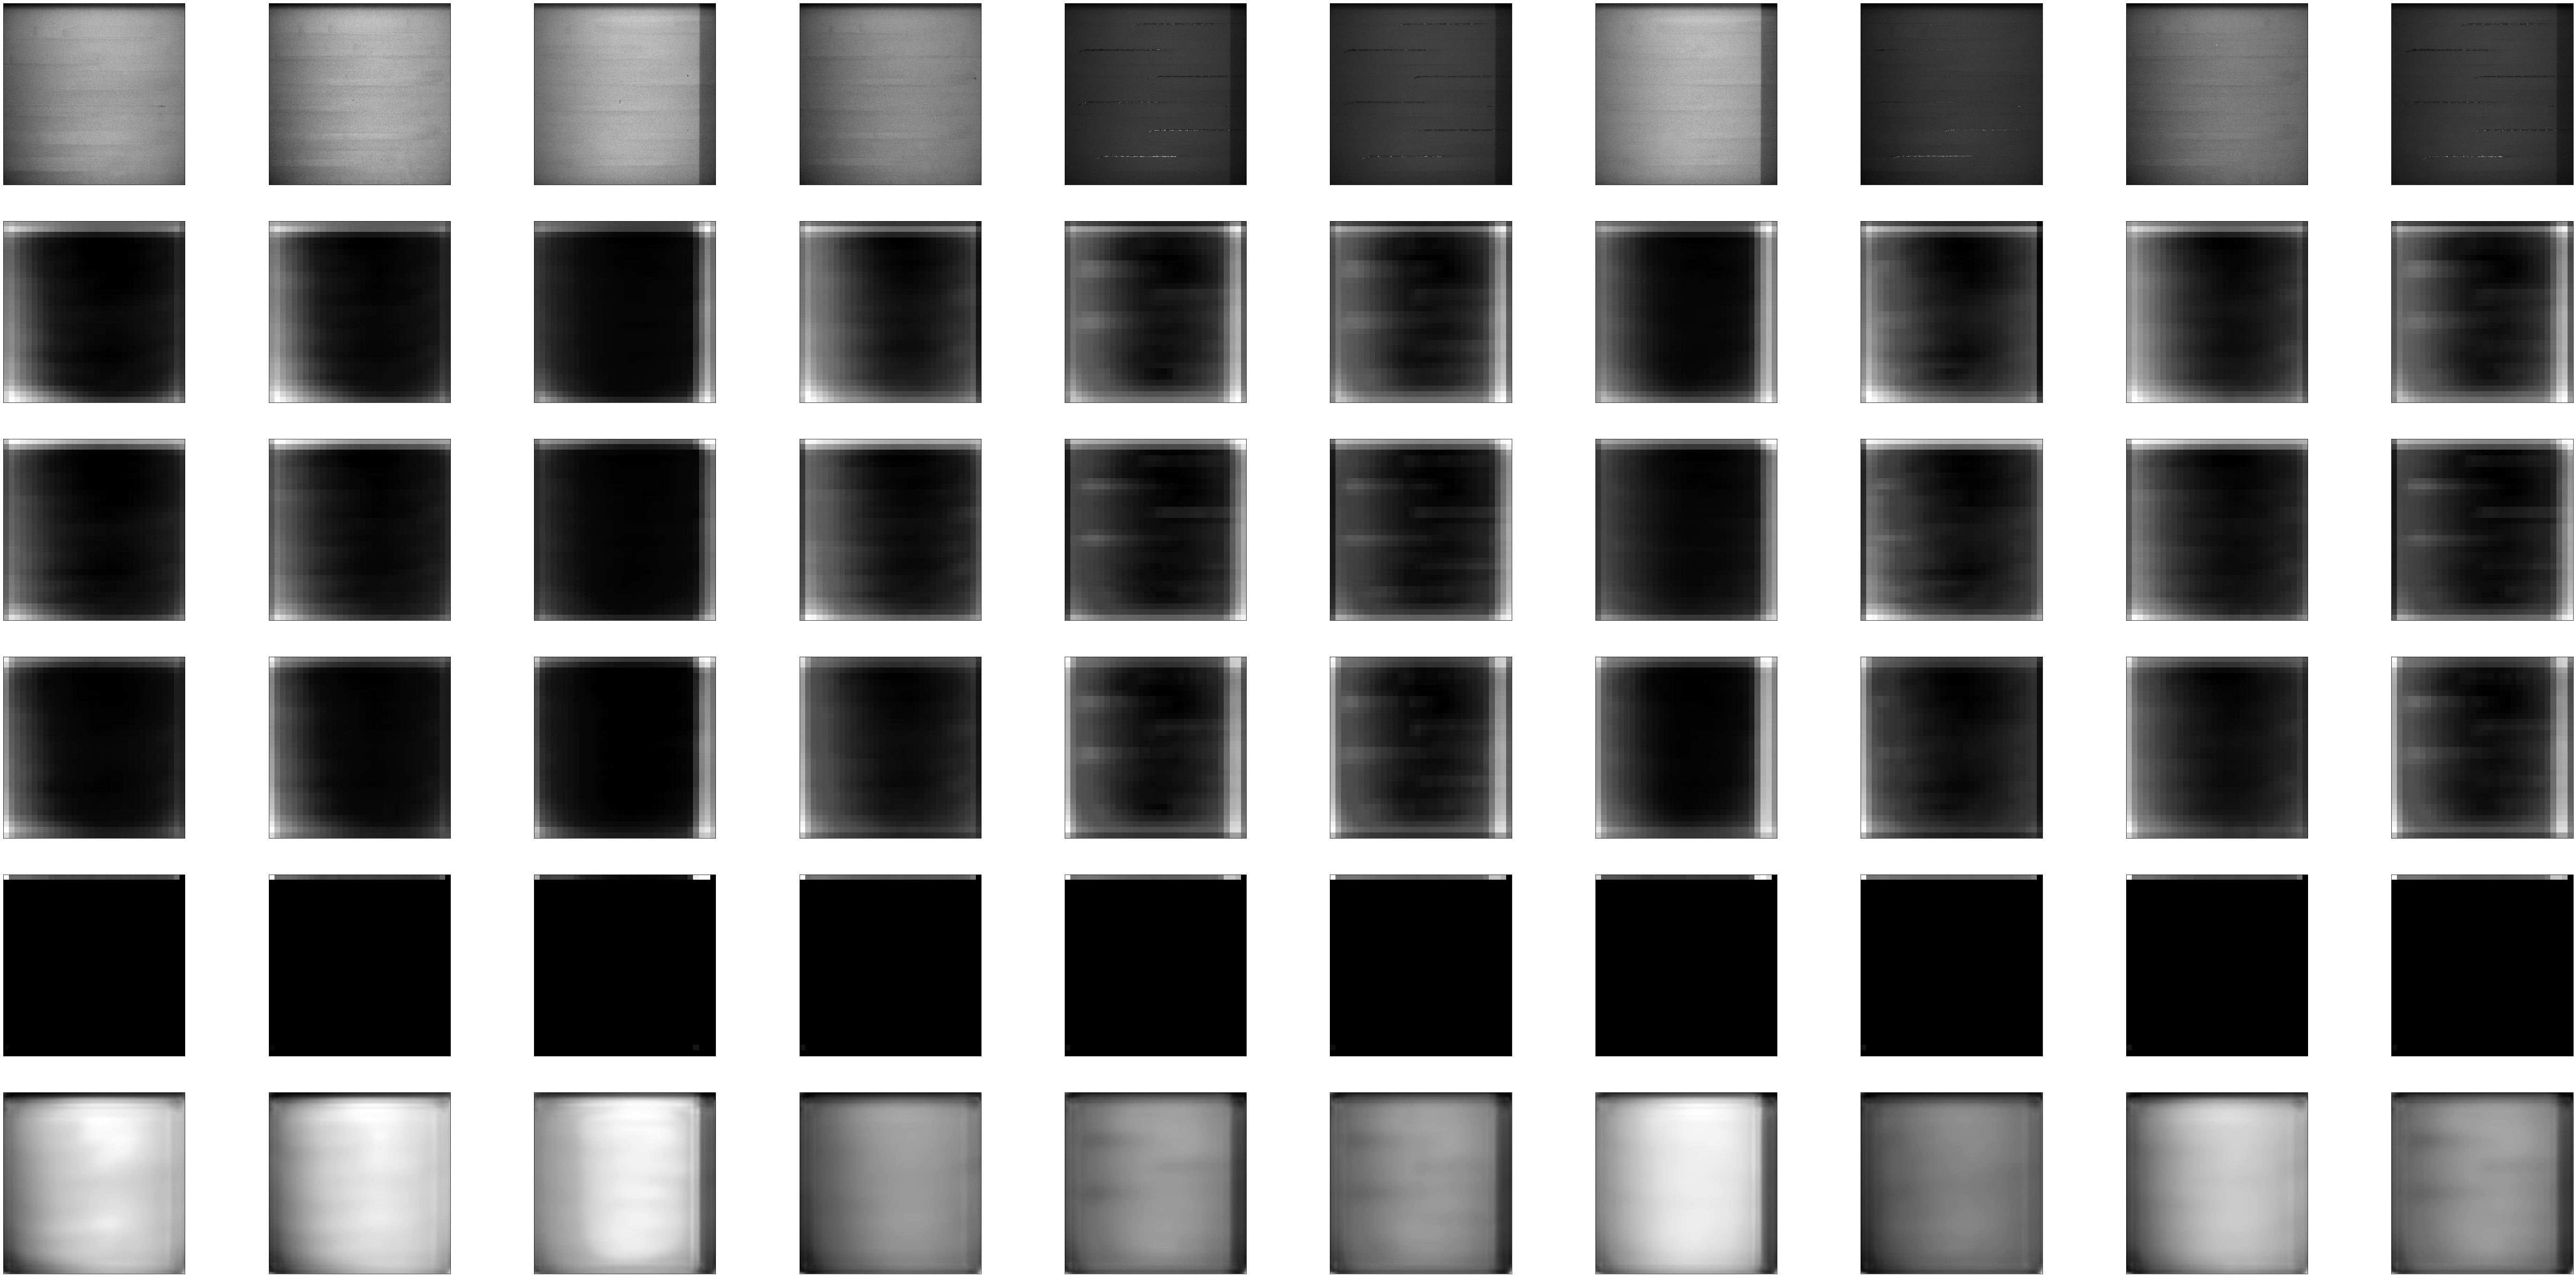

In [17]:
# Plotting the images (original - encoded - decoded)

plt.figure(figsize=(100, 50))
for i in range(10):
    # display original images
    ax = plt.subplot(6, 10, i + 1)
    plt.imshow((data_512_defect[i+10]).reshape(512, 512))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images (one per filter)
    for j in range(encoded_imgs_512_cnn.shape[3]):
        ax = plt.subplot(6, 10, i + j*10 + 1 + 10)
        plt.imshow(encoded_imgs_512_cnn[i+10,:,:,j].reshape(32,32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(6, 10, 50 + i + 1)
    plt.imshow(decoded_imgs_512_cnn[i+10].reshape(512, 512))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

In [12]:
# Proxy testing
# encoded_imgs_512_cnn = encoder_512_cnn.predict(data_512_holdout[:, :, :, ])
# decoded_imgs_512_cnn_holdout = autoencoder_512_cnn.predict(data_512_holdout[:, :, :, ])
# decoded_imgs_512_cnn_defect = autoencoder_512_cnn.predict(data_512_defect[:, :, :, ])


for threshold in range(1765, 1795, 5):
    total_diff_holdout = []
    anomalies_holdout = []
    
    for i in range(data_512_holdout.shape[0]):
        diff_1 = np.absolute((data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn_holdout[i]*255.).mean())
        diff_2 = np.linalg.norm(data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn_holdout[i]*255.)
        diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn_holdout[i]*255., (512, 512)),
                                          np.reshape(data_512_holdout[i, :, :, ]*255., (512, 512)))
        diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

        total_diff_holdout.append(diff_total)

        if diff_total >= threshold:
            anomalies_holdout.append(1)

    FP = np.sum(anomalies_holdout)
    TN = data_512_holdout.shape[0] - FP

    total_diff_defect = []
    anomalies_defect = []
    for i in range(data_512_defect.shape[0]):
        diff_1 = np.absolute((data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn_defect[i]*255.).mean())
        diff_2 = np.linalg.norm(data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn_defect[i]*255.)
        diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn_defect[i]*255., (512, 512)),
                                          np.reshape(data_512_defect[i, :, :, ]*255., (512, 512)))
        diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

        total_diff_defect.append(diff_total)

        if diff_total >= threshold:
            anomalies_defect.append(1)

    TP = np.sum(anomalies_defect)
    FN = data_512_defect.shape[0] - TP

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2 * (precision*recall)/(precision+recall)

    print("Threshold: {0}".format(threshold))
    print("False positive: {0}".format(FP))
    print("True negative: {0}".format(TN))
    print("True positive: {0}".format(TP))
    print("False negative: {0}".format(FN))
    print("Precision: {0}".format(precision))
    print("Recall: {0}".format(recall))
    print("F1: {0}".format(F1))
    print("----------")

Threshold: 1765
False positive: 1110
True negative: 1167
True positive: 64
False negative: 62
Precision: 0.054514480408858604
Recall: 0.5079365079365079
F1: 0.09846153846153846
----------
Threshold: 1770
False positive: 1104
True negative: 1173
True positive: 64
False negative: 62
Precision: 0.0547945205479452
Recall: 0.5079365079365079
F1: 0.09891808346213292
----------
Threshold: 1775
False positive: 1104
True negative: 1173
True positive: 64
False negative: 62
Precision: 0.0547945205479452
Recall: 0.5079365079365079
F1: 0.09891808346213292
----------
Threshold: 1780
False positive: 1098
True negative: 1179
True positive: 64
False negative: 62
Precision: 0.055077452667814115
Recall: 0.5079365079365079
F1: 0.09937888198757763
----------
Threshold: 1785
False positive: 1096
True negative: 1181
True positive: 64
False negative: 62
Precision: 0.05517241379310345
Recall: 0.5079365079365079
F1: 0.09953343701399689
----------
Threshold: 1790
False positive: 1091
True negative: 1186
True pos

# 512 x 512 (32->8)

## Build model

In [3]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

#Random seed
np.random.seed(42)

# Network architecture
input_image_512_cnn = Input(shape=(512, 512, 1))

# Encoding
encoded_512_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(input_image_512_cnn)
encoded_512_cnn = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn)

encoded_512_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded_512_cnn)
encoded_512_cnn = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn)

encoded_512_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_512_cnn)
encoded_512_cnn = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn)

encoded_512_cnn = Conv2D(8, (5, 5), activation='relu', padding='same')(encoded_512_cnn)
encoded_512_cnn = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn)


# Decoding
decoded_512_cnn = Conv2D(8, (5, 5), activation='relu', padding='same')(encoded_512_cnn)
decoded_512_cnn = UpSampling2D((2, 2))(decoded_512_cnn)

decoded_512_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(decoded_512_cnn)
decoded_512_cnn = UpSampling2D((2, 2))(decoded_512_cnn)

decoded_512_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_512_cnn)
decoded_512_cnn = UpSampling2D((2, 2))(decoded_512_cnn)

decoded_512_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_512_cnn)
decoded_512_cnn = UpSampling2D((2, 2))(decoded_512_cnn)

decoded_512_cnn = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(decoded_512_cnn)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# Autoencoder
autoencoder_512_cnn = Model(input_image_512_cnn, decoded_512_cnn)

# Encoder
encoder_512_cnn = Model(input_image_512_cnn, encoded_512_cnn)

autoencoder_512_cnn.compile(optimizer='adadelta', loss='mse')

In [6]:
# load weights into new model
autoencoder_512_cnn.load_weights("./autoencoder_cnn_512_3232_deep.h5")
print("Loaded model from disk")

Loaded model from disk


In [7]:
# Proxy testing
# encoded_imgs_512_cnn = encoder_512_cnn.predict(data_512_holdout[:, :, :, ])
decoded_imgs_512_cnn = autoencoder_512_cnn.predict(data_512_holdout[:, :, :, ])

In [8]:
difference_mean = []
for i in range(data_512_holdout.shape[0]):
    diff = (data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_512_holdout.shape[0]):
    diff = np.linalg.norm(data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_512_holdout.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn[i]*255., (512, 512)),
                                      np.reshape(data_512_holdout[i, :, :, ]*255., (512, 512)))
    
    difference_mse.append(diff)
    

In [9]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(-2.1509714807056612, 2842.7241325359505, 33.98676358976834)

In [10]:
total_diff = []
anomalies = []
for i in range(data_512_holdout.shape[0]):
    diff_1 = (data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn[i]*255., (512, 512)),
                                      np.reshape(data_512_holdout[i, :, :, ]*255., (512, 512)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1460:
        anomalies.append(1)

In [11]:
np.mean(total_diff)

948.6047751328543

In [12]:
# Proxy testing
encoded_imgs_512_cnn = encoder_512_cnn.predict(data_512_defect[:, :, :, ])
decoded_imgs_512_cnn = autoencoder_512_cnn.predict(data_512_defect[:, :, :, ])


In [13]:
difference_mean = []
for i in range(data_512_defect.shape[0]):
    diff = (data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_512_defect.shape[0]):
    diff = np.linalg.norm(data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_512_defect.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn[i]*255., (512, 512)),
                                      np.reshape(data_512_defect[i, :, :, ]*255., (512, 512)))
    
    difference_mse.append(diff)
    

In [14]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(-2.1285585403906486, 2731.4603447051522, 29.77424378981812)

In [15]:
total_diff = []
anomalies = []
for i in range(data_512_defect.shape[0]):
    diff_1 = (data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn[i]*255., (512, 512)),
                                      np.reshape(data_512_defect[i, :, :, ]*255., (512, 512)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1460:
        anomalies.append(1)

In [16]:
np.mean(total_diff)

910.5049898850115

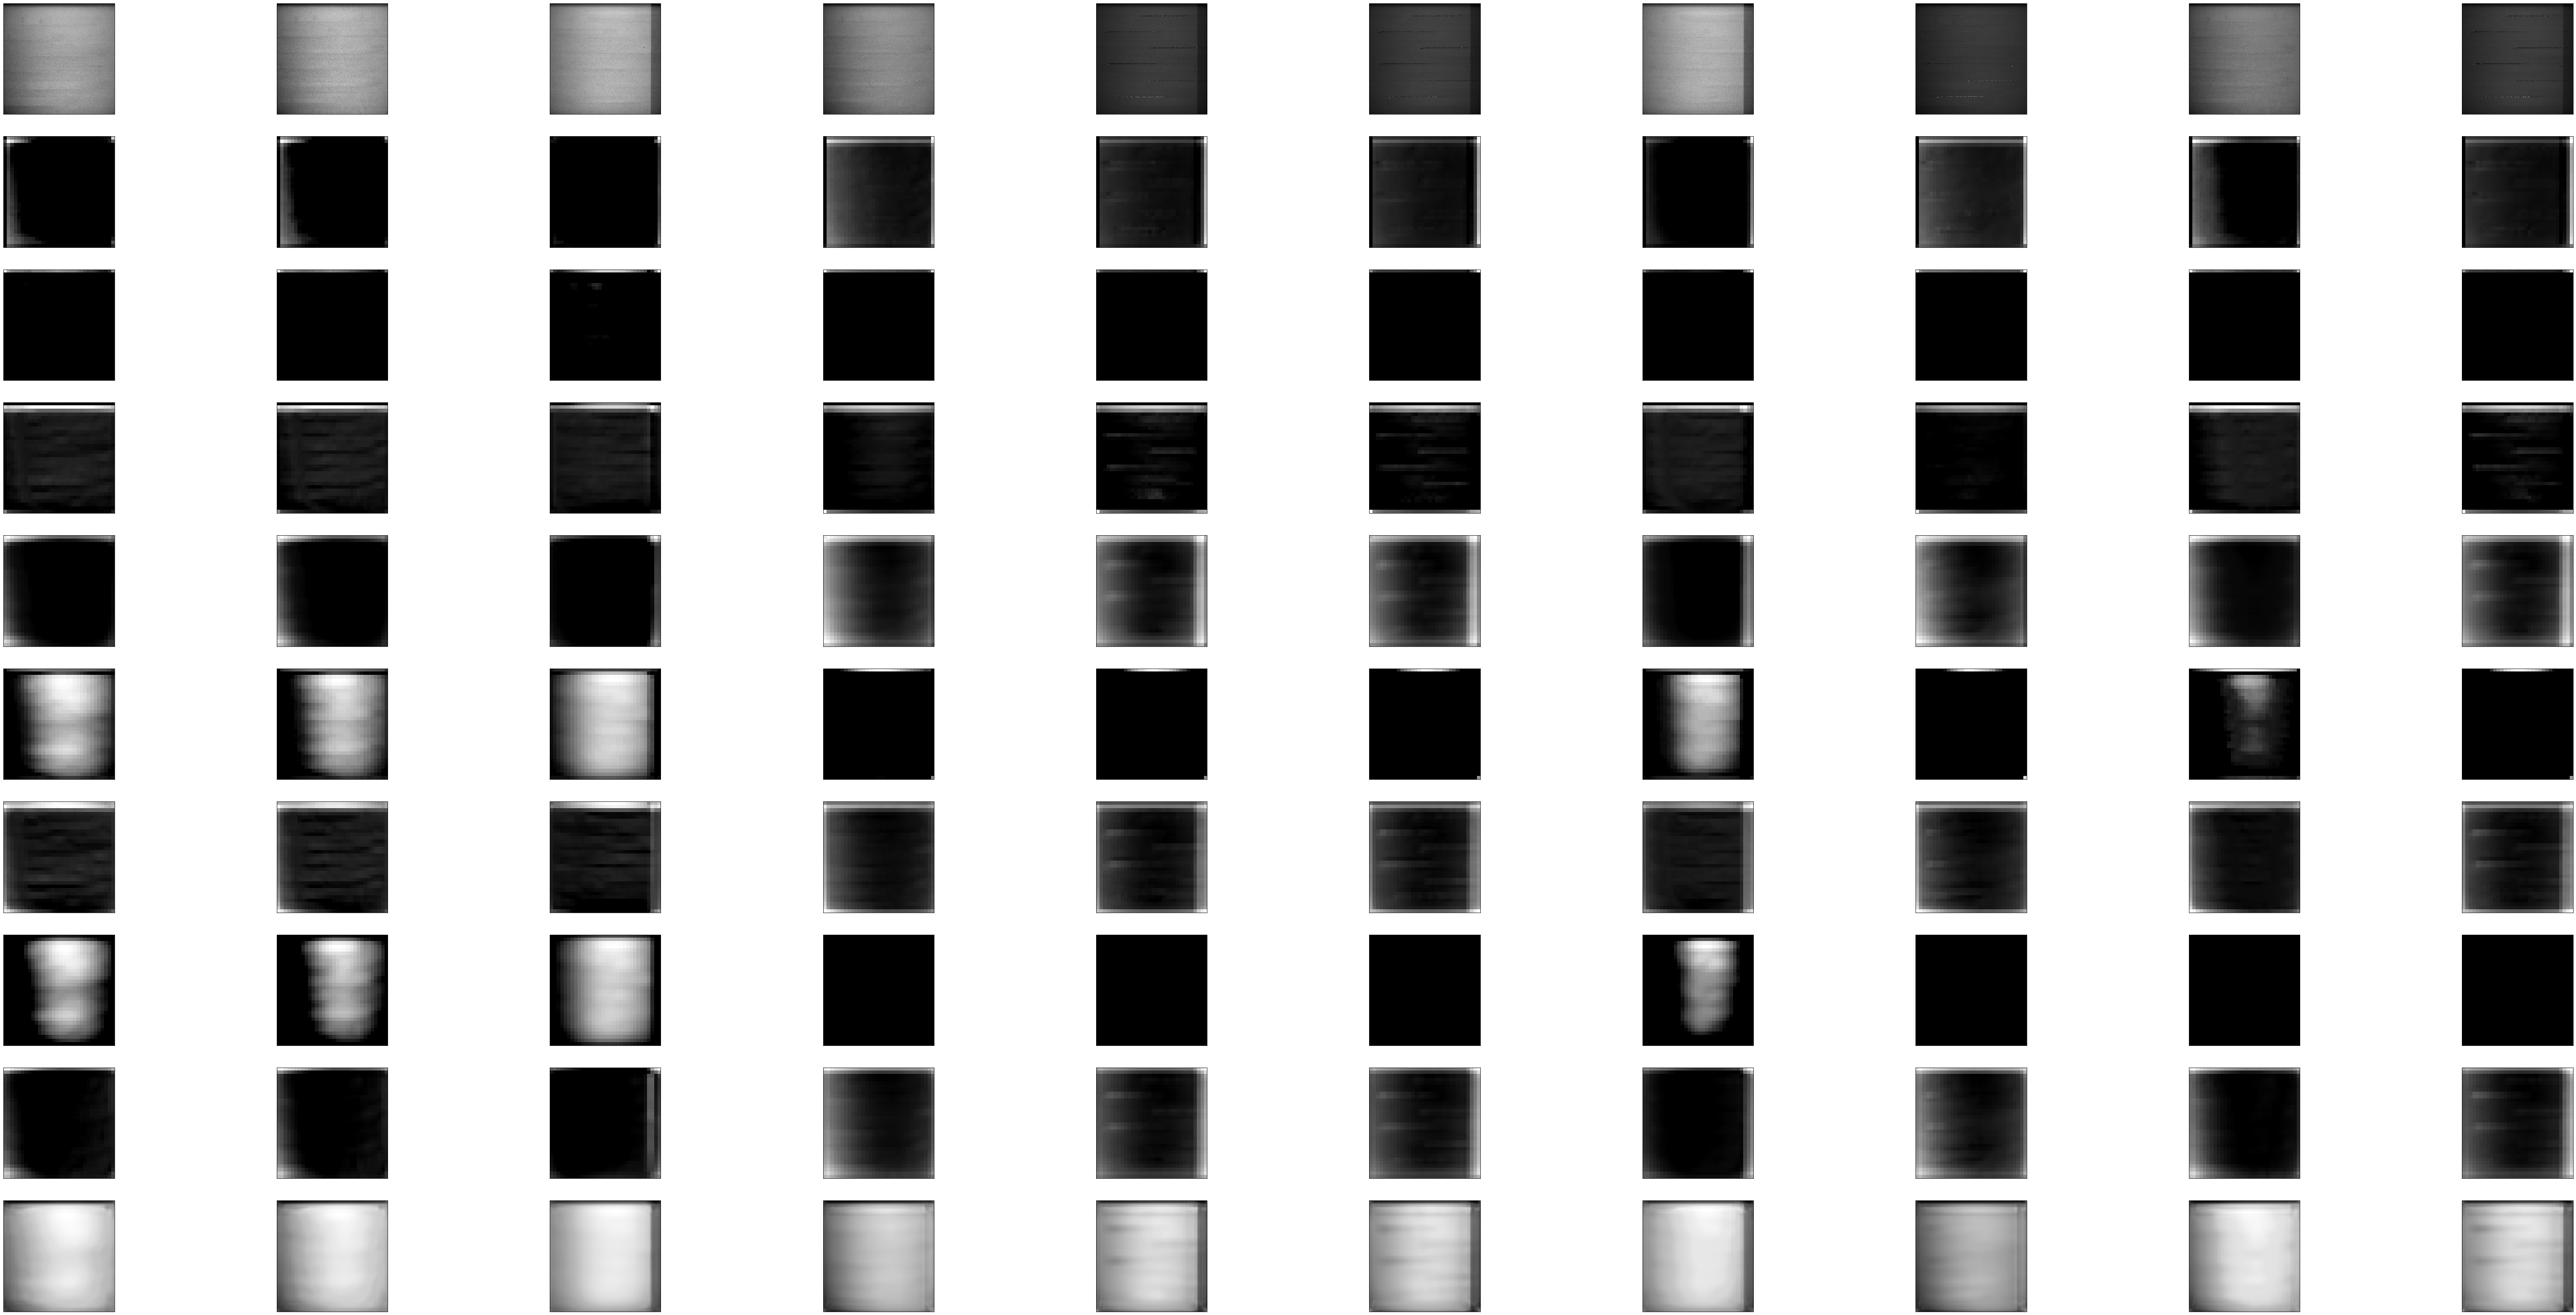

In [17]:
# Plotting the images (original - encoded - decoded)

plt.figure(figsize=(100, 50))
for i in range(10):
    # display original images
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow((data_512_defect[i+10]).reshape(512, 512))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images (one per filter)
    for j in range(encoded_imgs_512_cnn.shape[3]):
        ax = plt.subplot(10, 10, i + j*10 + 1 + 10)
        plt.imshow(encoded_imgs_512_cnn[i+10,:,:,j].reshape(32,32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(10, 10, 90 + i + 1)
    plt.imshow(decoded_imgs_512_cnn[i+10].reshape(512, 512))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

In [18]:
# Proxy testing
# encoded_imgs_512_cnn = encoder_512_cnn.predict(data_512_holdout[:, :, :, ])
decoded_imgs_512_cnn_holdout = autoencoder_512_cnn.predict(data_512_holdout[:, :, :, ])
decoded_imgs_512_cnn_defect = autoencoder_512_cnn.predict(data_512_defect[:, :, :, ])


for threshold in range(900, 970, 5):
    total_diff_holdout = []
    anomalies_holdout = []
    
    for i in range(data_512_holdout.shape[0]):
        diff_1 = np.absolute((data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn_holdout[i]*255.).mean())
        diff_2 = np.linalg.norm(data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn_holdout[i]*255.)
        diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn_holdout[i]*255., (512, 512)),
                                          np.reshape(data_512_holdout[i, :, :, ]*255., (512, 512)))
        diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

        total_diff_holdout.append(diff_total)

        if diff_total >= threshold:
            anomalies_holdout.append(1)

    FP = np.sum(anomalies_holdout)
    TN = data_512_holdout.shape[0] - FP

    total_diff_defect = []
    anomalies_defect = []
    for i in range(data_512_defect.shape[0]):
        diff_1 = np.absolute((data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn_defect[i]*255.).mean())
        diff_2 = np.linalg.norm(data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn_defect[i]*255.)
        diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn_defect[i]*255., (512, 512)),
                                          np.reshape(data_512_defect[i, :, :, ]*255., (512, 512)))
        diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

        total_diff_defect.append(diff_total)

        if diff_total >= threshold:
            anomalies_defect.append(1)

    TP = np.sum(anomalies_defect)
    FN = data_512_defect.shape[0] - TP

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2 * (precision*recall)/(precision+recall)

    print("Threshold: {0}".format(threshold))
    print("False positive: {0}".format(FP))
    print("True negative: {0}".format(TN))
    print("True positive: {0}".format(TP))
    print("False negative: {0}".format(FN))
    print("Precision: {0}".format(precision))
    print("Recall: {0}".format(recall))
    print("F1: {0}".format(F1))
    print("----------")

Threshold: 900
False positive: 953
True negative: 1324
True positive: 51
False negative: 75
Precision: 0.05079681274900399
Recall: 0.40476190476190477
F1: 0.09026548672566372
----------
Threshold: 905
False positive: 948
True negative: 1329
True positive: 51
False negative: 75
Precision: 0.05105105105105105
Recall: 0.40476190476190477
F1: 0.09066666666666666
----------
Threshold: 910
False positive: 942
True negative: 1335
True positive: 51
False negative: 75
Precision: 0.0513595166163142
Recall: 0.40476190476190477
F1: 0.09115281501340483
----------
Threshold: 915
False positive: 938
True negative: 1339
True positive: 51
False negative: 75
Precision: 0.05156723963599596
Recall: 0.40476190476190477
F1: 0.09147982062780269
----------
Threshold: 920
False positive: 930
True negative: 1347
True positive: 51
False negative: 75
Precision: 0.05198776758409786
Recall: 0.40476190476190477
F1: 0.0921409214092141
----------
Threshold: 925
False positive: 922
True negative: 1355
True positive: 51

# 512x512 (6464)

In [5]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

#Random seed
np.random.seed(42)

# Network architecture
input_image_512_cnn = Input(shape=(512, 512, 1))

# Encoding
encoded_512_cnn = Conv2D(64, (5, 5), activation='relu', padding='same')(input_image_512_cnn)
encoded_512_cnn = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn)

encoded_512_cnn = Conv2D(64, (5, 5), activation='relu', padding='same')(encoded_512_cnn)
encoded_512_cnn = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn)

encoded_512_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded_512_cnn)
encoded_512_cnn = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn)

encoded_512_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_512_cnn)
encoded_512_cnn = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn)


# Decoding
decoded_512_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_512_cnn)
decoded_512_cnn = UpSampling2D((2, 2))(decoded_512_cnn)

decoded_512_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_512_cnn)
decoded_512_cnn = UpSampling2D((2, 2))(decoded_512_cnn)

decoded_512_cnn = Conv2D(64, (5, 5), activation='relu', padding='same')(decoded_512_cnn)
decoded_512_cnn = UpSampling2D((2, 2))(decoded_512_cnn)

decoded_512_cnn = Conv2D(64, (5, 5), activation='relu', padding='same')(decoded_512_cnn)
decoded_512_cnn = UpSampling2D((2, 2))(decoded_512_cnn)

decoded_512_cnn = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(decoded_512_cnn)

In [6]:
# Autoencoder
autoencoder_512_cnn = Model(input_image_512_cnn, decoded_512_cnn)

# Encoder
encoder_512_cnn = Model(input_image_512_cnn, encoded_512_cnn)

autoencoder_512_cnn.compile(optimizer='adadelta', loss='mse')

In [7]:
# load weights into new model
autoencoder_512_cnn.load_weights("./autoencoder_cnn_512_6464_deep.h5")
print("Loaded model from disk")

Loaded model from disk


In [8]:
# Proxy testing
# encoded_imgs_512_cnn = encoder_512_cnn.predict(data_512_holdout[:, :, :, ])
decoded_imgs_512_cnn = autoencoder_512_cnn.predict(data_512_holdout[:, :, :, ])

In [9]:
difference_mean = []
for i in range(data_512_holdout.shape[0]):
    diff = (data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_512_holdout.shape[0]):
    diff = np.linalg.norm(data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_512_holdout.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn[i]*255., (512, 512)),
                                      np.reshape(data_512_holdout[i, :, :, ]*255., (512, 512)))
    
    difference_mse.append(diff)
    

In [10]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(6.09333050612055, 4772.851588951541, 119.38219934952056)

In [11]:
total_diff = []
anomalies = []
for i in range(data_512_holdout.shape[0]):
    diff_1 = (data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn[i]*255., (512, 512)),
                                      np.reshape(data_512_holdout[i, :, :, ]*255., (512, 512)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1460:
        anomalies.append(1)

In [12]:
np.mean(total_diff)

1616.4479492063701

In [13]:
# Proxy testing
encoded_imgs_512_cnn = encoder_512_cnn.predict(data_512_defect[:, :, :, ])
decoded_imgs_512_cnn = autoencoder_512_cnn.predict(data_512_defect[:, :, :, ])


In [14]:
difference_mean = []
for i in range(data_512_defect.shape[0]):
    diff = (data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_512_defect.shape[0]):
    diff = np.linalg.norm(data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_512_defect.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn[i]*255., (512, 512)),
                                      np.reshape(data_512_defect[i, :, :, ]*255., (512, 512)))
    
    difference_mse.append(diff)
    

In [15]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(5.867321388035057, 4740.157710289908, 111.69535004301326)

In [16]:
total_diff = []
anomalies = []
for i in range(data_512_defect.shape[0]):
    diff_1 = (data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn[i]*255., (512, 512)),
                                      np.reshape(data_512_defect[i, :, :, ]*255., (512, 512)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1460:
        anomalies.append(1)

In [17]:
np.mean(total_diff)

1603.0477259679158

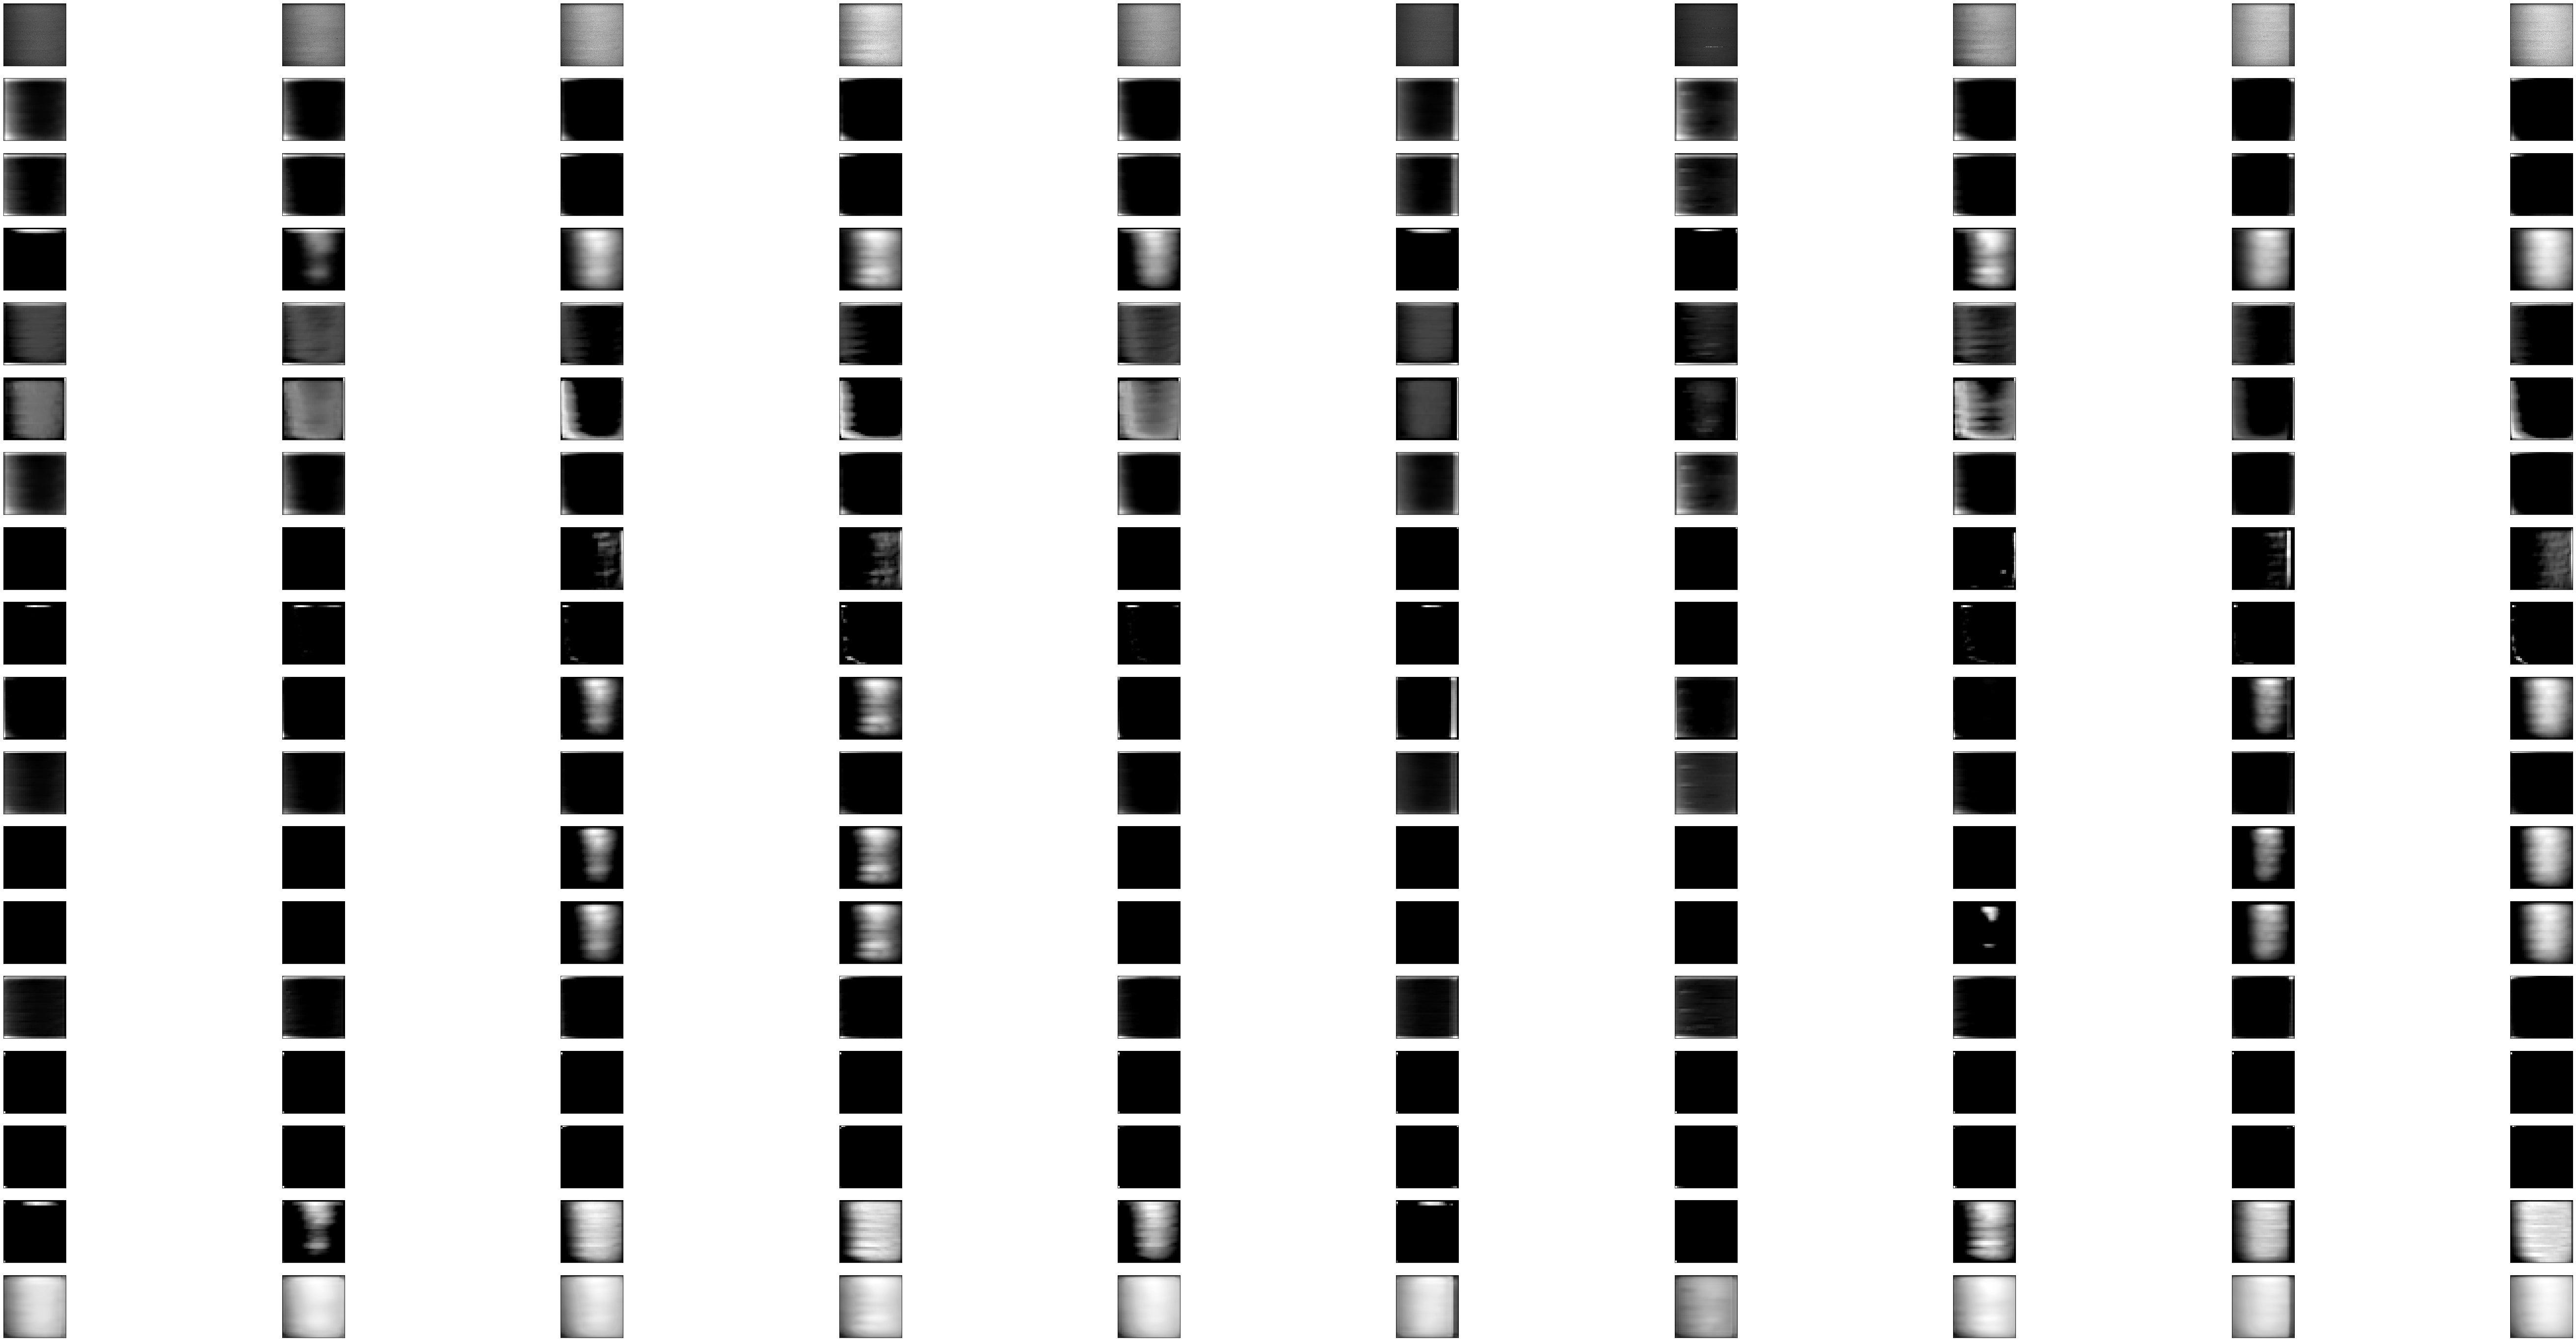

In [22]:
# Plotting the images (original - encoded - decoded)

plt.figure(figsize=(100, 50))
for i in range(10):
    # display original images
    ax = plt.subplot(18, 10, i + 1)
    plt.imshow((data_512_defect[i]/255.).reshape(512, 512))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images (one per filter)
    for j in range(encoded_imgs_512_cnn.shape[3]):
        ax = plt.subplot(18, 10, i + j*10 + 1 + 10)
        plt.imshow(encoded_imgs_512_cnn[i,:,:,j].reshape(32,32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(18, 10, 170 + i + 1)
    plt.imshow(decoded_imgs_512_cnn[i].reshape(512, 512))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

In [23]:
# Proxy testing
# encoded_imgs_512_cnn = encoder_512_cnn.predict(data_512_holdout[:, :, :, ])
decoded_imgs_512_cnn_holdout = autoencoder_512_cnn.predict(data_512_holdout[:, :, :, ])
decoded_imgs_512_cnn_defect = autoencoder_512_cnn.predict(data_512_defect[:, :, :, ])


for threshold in range(1595, 1630, 5):
    total_diff_holdout = []
    anomalies_holdout = []
    
    for i in range(data_512_holdout.shape[0]):
        diff_1 = np.absolute((data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn_holdout[i]*255.).mean())
        diff_2 = np.linalg.norm(data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn_holdout[i]*255.)
        diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn_holdout[i]*255., (512, 512)),
                                          np.reshape(data_512_holdout[i, :, :, ]*255., (512, 512)))
        diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

        total_diff_holdout.append(diff_total)

        if diff_total >= threshold:
            anomalies_holdout.append(1)

    FP = np.sum(anomalies_holdout)
    TN = data_512_holdout.shape[0] - FP

    total_diff_defect = []
    anomalies_defect = []
    for i in range(data_512_defect.shape[0]):
        diff_1 = np.absolute((data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn_defect[i]*255.).mean())
        diff_2 = np.linalg.norm(data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn_defect[i]*255.)
        diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn_defect[i]*255., (512, 512)),
                                          np.reshape(data_512_defect[i, :, :, ]*255., (512, 512)))
        diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

        total_diff_defect.append(diff_total)

        if diff_total >= threshold:
            anomalies_defect.append(1)

    TP = np.sum(anomalies_defect)
    FN = data_512_defect.shape[0] - TP

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2 * (precision*recall)/(precision+recall)

    print("Threshold: {0}".format(threshold))
    print("False positive: {0}".format(FP))
    print("True negative: {0}".format(TN))
    print("True positive: {0}".format(TP))
    print("False negative: {0}".format(FN))
    print("Precision: {0}".format(precision))
    print("Recall: {0}".format(recall))
    print("F1: {0}".format(F1))
    print("----------")

Threshold: 1595
False positive: 988
True negative: 1289
True positive: 59
False negative: 67
Precision: 0.05635148042024833
Recall: 0.46825396825396826
F1: 0.10059676044330777
----------
Threshold: 1600
False positive: 982
True negative: 1295
True positive: 59
False negative: 67
Precision: 0.056676272814601344
Recall: 0.46825396825396826
F1: 0.1011139674378749
----------
Threshold: 1605
False positive: 981
True negative: 1296
True positive: 59
False negative: 67
Precision: 0.05673076923076923
Recall: 0.46825396825396826
F1: 0.10120068610634647
----------
Threshold: 1610
False positive: 980
True negative: 1297
True positive: 59
False negative: 67
Precision: 0.05678537054860443
Recall: 0.46825396825396826
F1: 0.10128755364806867
----------
Threshold: 1615
False positive: 979
True negative: 1298
True positive: 59
False negative: 67
Precision: 0.05684007707129094
Recall: 0.46825396825396826
F1: 0.1013745704467354
----------
Threshold: 1620
False positive: 978
True negative: 1299
True posit

# 512x512 (7epochs)

In [4]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

#Random seed
# np.random.seed(42)

# Network architecture
input_image_512_cnn = Input(shape=(512, 512, 1))

# Encoding
encoded_512_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(input_image_512_cnn)
encoded_512_cnn = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn)

encoded_512_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded_512_cnn)
encoded_512_cnn = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn)

encoded_512_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_512_cnn)
encoded_512_cnn = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn)

encoded_512_cnn = Conv2D(8, (5, 5), activation='relu', padding='same')(encoded_512_cnn)
encoded_512_cnn = MaxPooling2D((2, 2), padding='same')(encoded_512_cnn)


# Decoding
decoded_512_cnn = Conv2D(8, (5, 5), activation='relu', padding='same')(encoded_512_cnn)
decoded_512_cnn = UpSampling2D((2, 2))(decoded_512_cnn)

decoded_512_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(decoded_512_cnn)
decoded_512_cnn = UpSampling2D((2, 2))(decoded_512_cnn)

decoded_512_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_512_cnn)
decoded_512_cnn = UpSampling2D((2, 2))(decoded_512_cnn)

decoded_512_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_512_cnn)
decoded_512_cnn = UpSampling2D((2, 2))(decoded_512_cnn)

decoded_512_cnn = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(decoded_512_cnn)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# Autoencoder
autoencoder_512_cnn = Model(input_image_512_cnn, decoded_512_cnn)

# Encoder
encoder_512_cnn = Model(input_image_512_cnn, encoded_512_cnn)

autoencoder_512_cnn.compile(optimizer='adadelta', loss='mse')

In [6]:
# load weights into new model
autoencoder_512_cnn.load_weights("./autoencoder_cnn_512_3232_7epoch_deep.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
# Proxy testing
# encoded_imgs_512_cnn = encoder_512_cnn.predict(data_512_holdout[:, :, :, ])
decoded_imgs_512_cnn = autoencoder_512_cnn.predict(data_512_holdout[:, :, :, ])

In [ ]:
difference_mean = []
for i in range(data_512_holdout.shape[0]):
    diff = (data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_512_holdout.shape[0]):
    diff = np.linalg.norm(data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_512_holdout.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn[i]*255., (512, 512)),
                                      np.reshape(data_512_holdout[i, :, :, ]*255., (512, 512)))
    
    difference_mse.append(diff)
    

In [ ]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

In [ ]:
total_diff = []
anomalies = []
for i in range(data_512_holdout.shape[0]):
    diff_1 = (data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn[i]*255., (512, 512)),
                                      np.reshape(data_512_holdout[i, :, :, ]*255., (512, 512)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1460:
        anomalies.append(1)

In [ ]:
np.mean(total_diff)

In [ ]:
# Proxy testing
encoded_imgs_512_cnn = encoder_512_cnn.predict(data_512_defect[:, :, :, ])
decoded_imgs_512_cnn = autoencoder_512_cnn.predict(data_512_defect[:, :, :, ])


In [ ]:
difference_mean = []
for i in range(data_512_defect.shape[0]):
    diff = (data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_512_defect.shape[0]):
    diff = np.linalg.norm(data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_512_defect.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn[i]*255., (512, 512)),
                                      np.reshape(data_512_defect[i, :, :, ]*255., (512, 512)))
    
    difference_mse.append(diff)
    

In [ ]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

In [ ]:
total_diff = []
anomalies = []
for i in range(data_512_defect.shape[0]):
    diff_1 = (data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.).mean()
    diff_2 = np.linalg.norm(data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn[i]*255.)
    diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn[i]*255., (512, 512)),
                                      np.reshape(data_512_defect[i, :, :, ]*255., (512, 512)))
    diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33
    
    total_diff.append(diff_total)
    
    if diff_total >= 1460:
        anomalies.append(1)

In [ ]:
np.mean(total_diff)

In [ ]:
# Plotting the images (original - encoded - decoded)

plt.figure(figsize=(100, 50))
for i in range(10):
    # display original images
    ax = plt.subplot(18, 10, i + 1)
    plt.imshow((data_512_defect[i]/255.).reshape(512, 512))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images (one per filter)
    for j in range(encoded_imgs_512_cnn.shape[3]):
        ax = plt.subplot(18, 10, i + j*10 + 1 + 10)
        plt.imshow(encoded_imgs_512_cnn[i,:,:,j].reshape(32,32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(18, 10, 170 + i + 1)
    plt.imshow(decoded_imgs_512_cnn[i].reshape(512, 512))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

In [23]:
# Proxy testing
# encoded_imgs_512_cnn = encoder_512_cnn.predict(data_512_holdout[:, :, :, ])
decoded_imgs_512_cnn_holdout = autoencoder_512_cnn.predict(data_512_holdout[:, :, :, ])
decoded_imgs_512_cnn_defect = autoencoder_512_cnn.predict(data_512_defect[:, :, :, ])


for threshold in range(1595, 1630, 5):
    total_diff_holdout = []
    anomalies_holdout = []
    
    for i in range(data_512_holdout.shape[0]):
        diff_1 = np.absolute((data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn_holdout[i]*255.).mean())
        diff_2 = np.linalg.norm(data_512_holdout[i, :, :, ]*255. - decoded_imgs_512_cnn_holdout[i]*255.)
        diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn_holdout[i]*255., (512, 512)),
                                          np.reshape(data_512_holdout[i, :, :, ]*255., (512, 512)))
        diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

        total_diff_holdout.append(diff_total)

        if diff_total >= threshold:
            anomalies_holdout.append(1)

    FP = np.sum(anomalies_holdout)
    TN = data_512_holdout.shape[0] - FP

    total_diff_defect = []
    anomalies_defect = []
    for i in range(data_512_defect.shape[0]):
        diff_1 = np.absolute((data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn_defect[i]*255.).mean())
        diff_2 = np.linalg.norm(data_512_defect[i, :, :, ]*255. - decoded_imgs_512_cnn_defect[i]*255.)
        diff_3 = metrics.mean_squared_error(np.reshape(decoded_imgs_512_cnn_defect[i]*255., (512, 512)),
                                          np.reshape(data_512_defect[i, :, :, ]*255., (512, 512)))
        diff_total = diff_1*.33 + diff_2*.33 + diff_3*.33

        total_diff_defect.append(diff_total)

        if diff_total >= threshold:
            anomalies_defect.append(1)

    TP = np.sum(anomalies_defect)
    FN = data_512_defect.shape[0] - TP

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2 * (precision*recall)/(precision+recall)

    print("Threshold: {0}".format(threshold))
    print("False positive: {0}".format(FP))
    print("True negative: {0}".format(TN))
    print("True positive: {0}".format(TP))
    print("False negative: {0}".format(FN))
    print("Precision: {0}".format(precision))
    print("Recall: {0}".format(recall))
    print("F1: {0}".format(F1))
    print("----------")

Threshold: 1595
False positive: 988
True negative: 1289
True positive: 59
False negative: 67
Precision: 0.05635148042024833
Recall: 0.46825396825396826
F1: 0.10059676044330777
----------
Threshold: 1600
False positive: 982
True negative: 1295
True positive: 59
False negative: 67
Precision: 0.056676272814601344
Recall: 0.46825396825396826
F1: 0.1011139674378749
----------
Threshold: 1605
False positive: 981
True negative: 1296
True positive: 59
False negative: 67
Precision: 0.05673076923076923
Recall: 0.46825396825396826
F1: 0.10120068610634647
----------
Threshold: 1610
False positive: 980
True negative: 1297
True positive: 59
False negative: 67
Precision: 0.05678537054860443
Recall: 0.46825396825396826
F1: 0.10128755364806867
----------
Threshold: 1615
False positive: 979
True negative: 1298
True positive: 59
False negative: 67
Precision: 0.05684007707129094
Recall: 0.46825396825396826
F1: 0.1013745704467354
----------
Threshold: 1620
False positive: 978
True negative: 1299
True posit